# Structure embedding evaluation (315 repositories / train set)

## 1. Loading repository information

In [1]:
!pip install gdown
!gdown 1sJDBLvVRvl4Sx0ICGuoM27pREIg0M756

Downloading...
From: https://drive.google.com/uc?id=1sJDBLvVRvl4Sx0ICGuoM27pREIg0M756
To: /content/repo_info_train.pkl
100% 201M/201M [00:03<00:00, 50.8MB/s]


In [2]:
import pickle

with open("repo_info_train.pkl", "rb") as f:
    repo_info = pickle.load(f)
    f.close()

## 2. Download pre-trained model

In [4]:
!pip3 install torch
!pip3 install transformers
!pip3 install sentence-transformers
!wget https://raw.githubusercontent.com/microsoft/CodeBERT/master/UniXcoder/unixcoder.py
# !curl -O https://raw.githubusercontent.com/microsoft/CodeBERT/master/UniXcoder/unixcoder.py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 99.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 115.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.1 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=3fd9d994650f1390ca67e37ae5feb038bc02b42e8f809bf59b99f6ed4e310362
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers
--2023-07-04 10:06:19--  https://raw.githubusercontent.com/microsoft/CodeBERT/master/UniXcoder/unixcoder.py
Resolving raw.githubusercontent.com (raw.git

In [5]:
import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

cuda


In [6]:
sentence_transformer_model_names = [
    "sentence-transformers/all-mpnet-base-v2",
    "sentence-transformers/multi-qa-mpnet-base-cos-v1",
    "sentence-transformers/bert-base-nli-mean-tokens",
    "sentence-transformers/paraphrase-multilingual-mpnet-base-v2",
    "sentence-transformers/all-distilroberta-v1",
    "sentence-transformers/distilbert-base-nli-mean-tokens"
]

In [7]:
from unixcoder import UniXcoder
from sentence_transformers import SentenceTransformer

sentence_transformer_models = {}

# Initialise sentence transformer model
for s_name in sentence_transformer_model_names:
    sentence_transformer_models[s_name] = SentenceTransformer(model_name_or_path=s_name, device=device)

## 3. Generating structure embeddings

In [8]:
# Getting other embbeddings
def get_other_embeddings(data_list):
    embeddings = {}

    # Sentence transformer model
    for s_name, s_model in tqdm(sentence_transformer_models.items()):
        print(f" - Using {s_name} model - ")
        embeddings_list = s_model.encode(data_list, convert_to_tensor=True)
        embeddings[s_name] = embeddings_list

    return embeddings


# Getting embeddings
def get_embeddings(input_data=None, input_mode=None):
    if input_data is None or not input_data:
        return torch.zeros((768,), device=device)

    with torch.no_grad():
        if input_mode == "structure":
            return get_other_embeddings(input_data)


In [9]:
from tqdm import tqdm

for repo_name, repo_dict in tqdm(repo_info.items()):
    print(f" - Generating structure embeddings for {repo_name} - ")
    repo_dict["structure_embeddings"] = get_embeddings(input_data=repo_dict["structure"], input_mode="structure")

  0%|          | 0/315 [00:00<?, ?it/s]

 - Generating structure embeddings for jet-admin/jet-bridge - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 33%|███▎      | 2/6 [00:08<00:13,  3.48s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|█████     | 3/6 [00:08<00:05,  1.95s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



  0%|          | 1/315 [00:09<47:13,  9.03s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for patrys/httmock - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 


100%|██████████| 6/6 [00:00<00:00, 77.64it/s]


 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for pytransitions/transitions - 



  1%|          | 3/315 [00:09<12:29,  2.40s/it]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for keleshev/schema - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 


100%|██████████| 6/6 [00:00<00:00, 75.65it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for dylanaraps/pywal - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


  2%|▏         | 5/315 [00:09<06:15,  1.21s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for PyCQA/modernize - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 79.82it/s]


 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for jaraco/path.py - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


  2%|▏         | 7/315 [00:09<03:45,  1.37it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for xonsh/xonsh - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 78.45it/s]


 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for python-excel/xlrd - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


  3%|▎         | 9/315 [00:09<02:29,  2.05it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for cloudnativelabs/kube-shell - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 79.25it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for ironmussa/Optimus - 




  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


  3%|▎         | 11/315 [00:09<01:45,  2.89it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for jazzband/django-taggit - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 78.53it/s]


 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for moggers87/salmon - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


  4%|▍         | 13/315 [00:10<01:18,  3.85it/s]

 - Generating structure embeddings for glamp/bashplotlib - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 69.89it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for PyCQA/prospector - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


  5%|▍         | 15/315 [00:10<01:01,  4.87it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for twisted/treq - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 77.09it/s]


 - Generating structure embeddings for bbangert/beaker - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


  5%|▌         | 17/315 [00:10<00:49,  5.98it/s]

 - Generating structure embeddings for pypa/bandersnatch - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 76.92it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for zachwill/moment - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


  6%|▌         | 19/315 [00:10<00:42,  7.04it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for encode/apistar - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 73.84it/s]


 - Generating structure embeddings for pyinvoke/invoke - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


  7%|▋         | 21/315 [00:10<00:36,  7.95it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for skorokithakis/shortuuid - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 


100%|██████████| 6/6 [00:00<00:00, 72.68it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for s3tools/s3cmd - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


  7%|▋         | 23/315 [00:10<00:33,  8.71it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for pyenv/pyenv - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 69.15it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 - Generating structure embeddings for stchris/untangle - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


  8%|▊         | 25/315 [00:11<00:31,  9.29it/s]

 - Generating structure embeddings for nvdv/vprof - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 77.77it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for h2oai/h2o-3 - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


  9%|▊         | 27/315 [00:11<00:29,  9.91it/s]

 - Generating structure embeddings for benhamner/Metrics - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 75.80it/s]


 - Generating structure embeddings for jmcarp/robobrowser - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 


  9%|▉         | 29/315 [00:11<00:27, 10.28it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for WiserTogether/django-remote-forms - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 71.38it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for mahmoud/boltons - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 72.35it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 10%|▉         | 31/315 [00:11<00:27, 10.50it/s]

 - Generating structure embeddings for stanfordnlp/stanza - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 75.31it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for keon/algorithms - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 10%|█         | 33/315 [00:11<00:26, 10.79it/s]

 - Generating structure embeddings for esnme/ultrajson - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 


100%|██████████| 6/6 [00:00<00:00, 74.82it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for boto/boto3 - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 11%|█         | 35/315 [00:11<00:25, 10.92it/s]

 - Generating structure embeddings for geopy/geopy - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 


100%|██████████| 6/6 [00:00<00:00, 72.05it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for sdispater/pendulum - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


 12%|█▏        | 37/315 [00:12<00:25, 11.01it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for omab/python-social-auth - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 71.25it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for django-guardian/django-guardian - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


 12%|█▏        | 39/315 [00:12<00:24, 11.05it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for mongodb/motor - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 


100%|██████████| 6/6 [00:00<00:00, 73.72it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for napalm-automation/napalm - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 


 13%|█▎        | 41/315 [00:12<00:24, 11.13it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for django-crispy-forms/django-crispy-forms - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 69.70it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 - Generating structure embeddings for mymarilyn/clickhouse-driver - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 14%|█▎        | 43/315 [00:12<00:24, 10.98it/s]

 - Generating structure embeddings for sdispater/orator - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 66.45it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 - Generating structure embeddings for codelucas/newspaper - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 14%|█▍        | 45/315 [00:12<00:24, 10.97it/s]

 - Generating structure embeddings for coleifer/huey - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 74.71it/s]


 - Generating structure embeddings for sympy/sympy - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 15%|█▍        | 47/315 [00:13<00:24, 11.17it/s]

 - Generating structure embeddings for gabrielfalcao/HTTPretty - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 73.92it/s]


 - Generating structure embeddings for elapouya/python-docx-template - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 16%|█▌        | 49/315 [00:13<00:23, 11.27it/s]

 - Generating structure embeddings for dahlia/wand - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 


100%|██████████| 6/6 [00:00<00:00, 72.84it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for mpdavis/python-jose - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 


 16%|█▌        | 51/315 [00:13<00:23, 11.20it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for shinux/PyTime - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 68.93it/s]


 - Generating structure embeddings for pymc-devs/pymc3 - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 17%|█▋        | 53/315 [00:13<00:23, 11.03it/s]

 - Generating structure embeddings for TheAlgorithms/Python - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 73.76it/s]


 - Generating structure embeddings for fabric/fabric - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


 17%|█▋        | 55/315 [00:13<00:23, 11.10it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for mindflayer/python-mocket - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 75.31it/s]


 - Generating structure embeddings for benfred/py-spy - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 18%|█▊        | 57/315 [00:13<00:23, 11.16it/s]

 - Generating structure embeddings for mikeorr/Unipath - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 77.07it/s]


 - Generating structure embeddings for unoconv/unoconv - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


 19%|█▊        | 59/315 [00:14<00:22, 11.16it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for google/google-api-python-client - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 66.26it/s]


 - Generating structure embeddings for sdispater/poetry - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 19%|█▉        | 61/315 [00:14<00:22, 11.06it/s]

 - Generating structure embeddings for dbader/schedule - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 75.47it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for dimka665/awesome-slugify - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 20%|██        | 63/315 [00:14<00:22, 11.22it/s]

 - Generating structure embeddings for timothycrosley/isort - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 72.08it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for mobolic/facebook-sdk - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


 21%|██        | 65/315 [00:14<00:22, 11.01it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for wemake-services/wemake-python-styleguide - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 72.58it/s]


 - Generating structure embeddings for dirn/When.py - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 69.57it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 21%|██▏       | 67/315 [00:14<00:22, 10.98it/s]

 - Generating structure embeddings for miso-belica/sumy - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 


100%|██████████| 6/6 [00:00<00:00, 69.35it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for davidaurelio/hashids-python - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 


 22%|██▏       | 69/315 [00:15<00:22, 10.90it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for noxrepo/pox - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 72.68it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for sqlmapproject/sqlmap - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


 23%|██▎       | 71/315 [00:15<00:22, 10.95it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for errbotio/errbot - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 77.27it/s]


 - Generating structure embeddings for jonathanslenders/python-prompt-toolkit - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 23%|██▎       | 73/315 [00:15<00:21, 11.18it/s]

 - Generating structure embeddings for jakubroztocil/httpie - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 68.23it/s]


 - Generating structure embeddings for cdgriffith/Box - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


 24%|██▍       | 75/315 [00:15<00:21, 11.08it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for python-openxml/python-docx - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 


100%|██████████| 6/6 [00:00<00:00, 76.73it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for gleitz/howdoi - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 24%|██▍       | 77/315 [00:15<00:21, 11.12it/s]

 - Generating structure embeddings for vinta/pangu.py - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 72.39it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 - Generating structure embeddings for derek73/python-nameparser - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 25%|██▌       | 79/315 [00:15<00:21, 10.98it/s]

 - Generating structure embeddings for cobrateam/splinter - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 67.01it/s]


 - Generating structure embeddings for keras-team/keras - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


 26%|██▌       | 81/315 [00:16<00:21, 10.69it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for Pylons/deform - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 72.67it/s]


 - Generating structure embeddings for facebook/pyre-check - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 26%|██▋       | 83/315 [00:16<00:21, 10.75it/s]

 - Generating structure embeddings for DiffSK/configobj - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 69.84it/s]


 - Generating structure embeddings for binux/pyspider - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 66.74it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 27%|██▋       | 85/315 [00:16<00:21, 10.68it/s]

 - Generating structure embeddings for getnikola/nikola - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 73.75it/s]


 - Generating structure embeddings for dask/dask - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 


 28%|██▊       | 87/315 [00:16<00:21, 10.81it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for mozilla/unicode-slugify - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 


100%|██████████| 6/6 [00:00<00:00, 70.29it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for devsnd/tinytag - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 28%|██▊       | 89/315 [00:16<00:21, 10.74it/s]

 - Generating structure embeddings for jazzband/pip-tools - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 66.11it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for gmr/queries - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


 29%|██▉       | 91/315 [00:17<00:21, 10.58it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for getsentry/sentry-python - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 68.69it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 - Generating structure embeddings for pallets/jinja - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 30%|██▉       | 93/315 [00:17<00:21, 10.54it/s]

 - Generating structure embeddings for rkern/line_profiler - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 66.01it/s]


 - Generating structure embeddings for marrow/mailer - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


 30%|███       | 95/315 [00:17<00:20, 10.51it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for gawel/pyquery - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 75.51it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for spotify/luigi - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 31%|███       | 97/315 [00:17<00:20, 10.81it/s]

 - Generating structure embeddings for devpi/devpi - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 


100%|██████████| 6/6 [00:00<00:00, 75.87it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for modoboa/modoboa - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


 31%|███▏      | 99/315 [00:17<00:19, 10.87it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for falconry/falcon - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 68.10it/s]


 - Generating structure embeddings for django-cache-machine/django-cache-machine - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 72.94it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 32%|███▏      | 101/315 [00:18<00:19, 10.87it/s]

 - Generating structure embeddings for martinrusev/imbox - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 65.41it/s]


 - Generating structure embeddings for lektor/lektor - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 33%|███▎      | 103/315 [00:18<00:19, 10.74it/s]

 - Generating structure embeddings for spotify/annoy - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 70.33it/s]


 - Generating structure embeddings for lincolnloop/python-qrcode - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 


 33%|███▎      | 105/315 [00:18<00:19, 10.87it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for miracle2k/flask-assets - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 74.54it/s]


 - Generating structure embeddings for hhatto/nude.py - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


 34%|███▍      | 107/315 [00:18<00:18, 10.95it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for timofurrer/maya - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 68.80it/s]


 - Generating structure embeddings for MicroPyramid/forex-python - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 35%|███▍      | 109/315 [00:18<00:19, 10.74it/s]

 - Generating structure embeddings for codeinthehole/purl - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 72.55it/s]


 - Generating structure embeddings for khamidou/lptrace - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 69.95it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 35%|███▌      | 111/315 [00:18<00:18, 10.83it/s]

 - Generating structure embeddings for altair-viz/altair - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 71.70it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for jendrikseipp/vulture - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 36%|███▌      | 113/315 [00:19<00:18, 10.82it/s]

 - Generating structure embeddings for Pylons/waitress - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 72.28it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for SerpentAI/SerpentAI - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


 37%|███▋      | 115/315 [00:19<00:18, 10.63it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for html5lib/html5lib-python - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 70.12it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for dmlc/mxnet - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 37%|███▋      | 117/315 [00:19<00:18, 10.67it/s]

 - Generating structure embeddings for django-haystack/pysolr - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 72.14it/s]


 - Generating structure embeddings for aizvorski/scikit-video - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 38%|███▊      | 119/315 [00:19<00:18, 10.75it/s]

 - Generating structure embeddings for sergree/matchering - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 75.41it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for ZoomerAnalytics/xlwings - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


 38%|███▊      | 121/315 [00:19<00:17, 10.89it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for jazzband/django-pipeline - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 68.62it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for clips/pattern - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 39%|███▉      | 123/315 [00:20<00:17, 10.77it/s]

 - Generating structure embeddings for fabianp/memory_profiler - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 70.28it/s]


 - Generating structure embeddings for mitsuhiko/unp - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


 40%|███▉      | 125/315 [00:20<00:17, 10.90it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for stephenmcd/hot-redis - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 73.17it/s]


 - Generating structure embeddings for henriquebastos/python-decouple - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 


 40%|████      | 127/315 [00:20<00:17, 11.03it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for marshmallow-code/webargs - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 69.02it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 - Generating structure embeddings for flask-api/flask-api - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 41%|████      | 129/315 [00:20<00:17, 10.94it/s]

 - Generating structure embeddings for ansible/ansible - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 68.04it/s]


 - Generating structure embeddings for amitt001/delegator.py - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 42%|████▏     | 131/315 [00:20<00:16, 10.85it/s]

 - Generating structure embeddings for SavinaRoja/PyUserInput - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 


100%|██████████| 6/6 [00:00<00:00, 67.05it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for MongoEngine/mongoengine - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


 42%|████▏     | 133/315 [00:20<00:17, 10.70it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for pybee/toga - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 71.48it/s]


 - Generating structure embeddings for google/yapf - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


 43%|████▎     | 135/315 [00:21<00:16, 10.88it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for Fizzadar/pyinfra - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 74.01it/s]


 - Generating structure embeddings for istrategylabs/django-wordpress - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 43%|████▎     | 137/315 [00:21<00:16, 10.99it/s]

 - Generating structure embeddings for zopefoundation/ZODB - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 69.86it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for boppreh/mouse - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 44%|████▍     | 139/315 [00:21<00:16, 10.97it/s]

 - Generating structure embeddings for justquick/django-activity-stream - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 72.92it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for benoitc/gunicorn - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 45%|████▍     | 141/315 [00:21<00:15, 11.06it/s]

 - Generating structure embeddings for prabhupant/python-ds - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 72.34it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for marshmallow-code/marshmallow - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 45%|████▌     | 143/315 [00:21<00:15, 10.96it/s]

 - Generating structure embeddings for coleifer/micawber - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 71.44it/s]


 - Generating structure embeddings for getsentry/responses - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 46%|████▌     | 145/315 [00:22<00:15, 10.92it/s]

 - Generating structure embeddings for joestump/python-oauth2 - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 77.26it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 - Generating structure embeddings for chapmanb/bcbb - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


 47%|████▋     | 147/315 [00:22<00:15, 10.97it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for Cornices/cornice - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 71.19it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for mozilla/bleach - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


 47%|████▋     | 149/315 [00:22<00:15, 11.01it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for selwin/python-user-agents - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 72.97it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for Suor/django-cacheops - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 69.92it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 48%|████▊     | 151/315 [00:22<00:14, 11.01it/s]

 - Generating structure embeddings for burnash/gspread - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 68.18it/s]


 - Generating structure embeddings for chapmanb/bcbio-nextgen - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 


 49%|████▊     | 153/315 [00:22<00:14, 10.88it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for django/daphne - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 70.11it/s]


 - Generating structure embeddings for stephenmcd/mezzanine - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 49%|████▉     | 155/315 [00:22<00:14, 10.87it/s]

 - Generating structure embeddings for PySimpleGUI/PySimpleGUI - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 


100%|██████████| 6/6 [00:00<00:00, 76.87it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for PrefectHQ/prefect - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


 50%|████▉     | 157/315 [00:23<00:14, 11.08it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for sunainapai/makesite - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 68.45it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 - Generating structure embeddings for BVLC/caffe - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 50%|█████     | 159/315 [00:23<00:14, 10.88it/s]

 - Generating structure embeddings for django/django - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 


100%|██████████| 6/6 [00:00<00:00, 69.09it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for keunwoochoi/kapre - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 51%|█████     | 161/315 [00:23<00:14, 10.91it/s]

 - Generating structure embeddings for awesto/django-shop - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 72.53it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for emirozer/fake2db - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


 52%|█████▏    | 163/315 [00:23<00:13, 11.06it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for lk-geimfari/mimesis - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 72.71it/s]


 - Generating structure embeddings for pennersr/django-allauth - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


 52%|█████▏    | 165/315 [00:23<00:13, 10.98it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for pyglet/pyglet - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 74.12it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for dmlc/xgboost - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 53%|█████▎    | 167/315 [00:24<00:13, 10.93it/s]

 - Generating structure embeddings for Maratyszcza/PeachPy - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 73.31it/s]


 - Generating structure embeddings for deanmalmgren/textract - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 


100%|██████████| 6/6 [00:00<00:00, 73.42it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 54%|█████▎    | 169/315 [00:24<00:13, 10.97it/s]

 - Generating structure embeddings for tschellenbach/Stream-Framework - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 70.21it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for pallets/itsdangerous - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


 54%|█████▍    | 171/315 [00:24<00:13, 11.02it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for wooey/wooey - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 70.64it/s]


 - Generating structure embeddings for huge-success/sanic - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


 55%|█████▍    | 173/315 [00:24<00:12, 11.01it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for chineking/cola - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 69.22it/s]


 - Generating structure embeddings for libvips/pyvips - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 56%|█████▌    | 175/315 [00:24<00:12, 10.96it/s]

 - Generating structure embeddings for srusskih/SublimeJEDI - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 72.94it/s]


 - Generating structure embeddings for hugapi/hug - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


 56%|█████▌    | 177/315 [00:24<00:12, 10.99it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for openai/gym - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 73.85it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for wtforms/wtforms - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


 57%|█████▋    | 179/315 [00:25<00:12, 10.99it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for Supervisor/supervisor - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 71.57it/s]


 - Generating structure embeddings for python-attrs/attrs - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 57%|█████▋    | 181/315 [00:25<00:12, 10.90it/s]

 - Generating structure embeddings for HypothesisWorks/hypothesis - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 66.75it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for quantopian/zipline - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 58%|█████▊    | 183/315 [00:25<00:12, 10.72it/s]

 - Generating structure embeddings for MechanicalSoup/MechanicalSoup - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 75.19it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 - Generating structure embeddings for saffsd/langid.py - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


 59%|█████▊    | 185/315 [00:25<00:11, 10.90it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for awslabs/aws-data-wrangler - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 72.02it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for vandersonmota/model_mommy - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 59%|█████▉    | 187/315 [00:25<00:11, 10.79it/s]

 - Generating structure embeddings for benedekrozemberczki/karateclub - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 67.96it/s]


 - Generating structure embeddings for statsmodels/statsmodels - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 60%|██████    | 189/315 [00:26<00:11, 10.77it/s]

 - Generating structure embeddings for pwaller/pyfiglet - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 72.78it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 - Generating structure embeddings for google/pyringe - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


 61%|██████    | 191/315 [00:26<00:11, 10.91it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for saltstack/salt - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 70.96it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for web2py/pydal - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 72.54it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 61%|██████▏   | 193/315 [00:26<00:11, 10.94it/s]

 - Generating structure embeddings for jorgenschaefer/elpy - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 70.53it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for lericson/pylibmc - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 62%|██████▏   | 195/315 [00:26<00:11, 10.87it/s]

 - Generating structure embeddings for Suor/funcy - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 68.67it/s]


 - Generating structure embeddings for carlosescri/DottedDict - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 63%|██████▎   | 197/315 [00:26<00:11, 10.73it/s]

 - Generating structure embeddings for mooz/percol - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 


100%|██████████| 6/6 [00:00<00:00, 68.17it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for jfkirk/tensorrec - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 63%|██████▎   | 199/315 [00:27<00:10, 10.73it/s]

 - Generating structure embeddings for r0x0r/pywebview - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 72.74it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for zoofIO/flexx - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 69.85it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 64%|██████▍   | 201/315 [00:27<00:10, 10.80it/s]

 - Generating structure embeddings for davidhalter/jedi-vim - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 64.77it/s]


 - Generating structure embeddings for mwaskom/seaborn - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 64%|██████▍   | 203/315 [00:27<00:10, 10.66it/s]

 - Generating structure embeddings for miracle2k/webassets - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 69.17it/s]


 - Generating structure embeddings for Alir3z4/html2text - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 65%|██████▌   | 205/315 [00:27<00:10, 10.70it/s]

 - Generating structure embeddings for sirfz/tesserocr - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 68.75it/s]


 - Generating structure embeddings for abhiTronix/vidgear - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


 66%|██████▌   | 207/315 [00:27<00:10, 10.70it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for gorakhargosh/watchdog - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 


100%|██████████| 6/6 [00:00<00:00, 63.26it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for CleanCut/green - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 


 66%|██████▋   | 209/315 [00:27<00:10, 10.58it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for jonashaag/bjoern - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 67.43it/s]


 - Generating structure embeddings for dyve/django-bootstrap3 - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


 67%|██████▋   | 211/315 [00:28<00:09, 10.48it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for RaylockLLC/DearPyGui - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 


100%|██████████| 6/6 [00:00<00:00, 71.34it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 - Generating structure embeddings for nficano/python-lambda - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 68%|██████▊   | 213/315 [00:28<00:09, 10.57it/s]

 - Generating structure embeddings for patx/pickledb - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 70.87it/s]


 - Generating structure embeddings for SmileyChris/django-countries - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 70.99it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 68%|██████▊   | 215/315 [00:28<00:09, 10.67it/s]

 - Generating structure embeddings for gunnery/gunnery - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 60.90it/s]


 - Generating structure embeddings for wireservice/csvkit - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 69%|██████▉   | 217/315 [00:28<00:09, 10.34it/s]

 - Generating structure embeddings for spotify/dh-virtualenv - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 69.81it/s]


 - Generating structure embeddings for podio/valideer - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 67.33it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 70%|██████▉   | 219/315 [00:28<00:09, 10.39it/s]

 - Generating structure embeddings for martinblech/xmltodict - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 68.65it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for carlospalol/money - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 70%|███████   | 221/315 [00:29<00:09, 10.41it/s]

 - Generating structure embeddings for pytoolz/toolz - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 67.98it/s]


 - Generating structure embeddings for un33k/python-slugify - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


 71%|███████   | 223/315 [00:29<00:08, 10.46it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for Julian/jsonschema - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 


100%|██████████| 6/6 [00:00<00:00, 65.22it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for pyfilesystem/pyfilesystem2 - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 71%|███████▏  | 225/315 [00:29<00:08, 10.40it/s]

 - Generating structure embeddings for faif/python-patterns - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 64.64it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for fengsp/plan - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


 72%|███████▏  | 227/315 [00:29<00:08, 10.31it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for pybuilder/pybuilder - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 70.12it/s]


 - Generating structure embeddings for ageitgey/face_recognition - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 


100%|██████████| 6/6 [00:00<00:00, 64.35it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 73%|███████▎  | 229/315 [00:29<00:08, 10.35it/s]

 - Generating structure embeddings for Bogdanp/dramatiq - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 


100%|██████████| 6/6 [00:00<00:00, 66.36it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for beetbox/beets - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


 73%|███████▎  | 231/315 [00:30<00:08, 10.35it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for Parsely/streamparse - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 70.71it/s]


 - Generating structure embeddings for rq/rq - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


 74%|███████▍  | 233/315 [00:30<00:07, 10.47it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for Parisson/TimeSide - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 67.81it/s]


 - Generating structure embeddings for daviddrysdale/python-phonenumbers - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 75%|███████▍  | 235/315 [00:30<00:07, 10.51it/s]

 - Generating structure embeddings for knipknap/SpiffWorkflow - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 71.37it/s]


 - Generating structure embeddings for jmcnamara/XlsxWriter - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 


100%|██████████| 6/6 [00:00<00:00, 74.09it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 75%|███████▌  | 237/315 [00:30<00:07, 10.66it/s]

 - Generating structure embeddings for LuminosoInsight/python-ftfy - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 67.29it/s]


 - Generating structure embeddings for gotcha/ipdb - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


 76%|███████▌  | 239/315 [00:30<00:07, 10.52it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for librosa/librosa - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 65.71it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for rochacbruno/quokka - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 77%|███████▋  | 241/315 [00:31<00:07, 10.55it/s]

 - Generating structure embeddings for pyca/pynacl - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 69.50it/s]


 - Generating structure embeddings for msiemens/tinydb - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 


 77%|███████▋  | 243/315 [00:31<00:06, 10.55it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for thumbor/thumbor - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 69.16it/s]


 - Generating structure embeddings for schematics/schematics - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 78%|███████▊  | 245/315 [00:31<00:06, 10.53it/s]

 - Generating structure embeddings for conda/conda - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 


100%|██████████| 6/6 [00:00<00:00, 72.55it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for kiwicom/schemathesis - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 


 78%|███████▊  | 247/315 [00:31<00:06, 10.70it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for nucleic/enaml - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 69.69it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 - Generating structure embeddings for mher/flower - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 79%|███████▉  | 249/315 [00:31<00:06, 10.68it/s]

 - Generating structure embeddings for SciTools/cartopy - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 74.40it/s]


 - Generating structure embeddings for pallets/markupsafe - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 


 80%|███████▉  | 251/315 [00:31<00:05, 10.84it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for nicfit/eyeD3 - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 63.05it/s]


 - Generating structure embeddings for magenta/magenta - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


 80%|████████  | 253/315 [00:32<00:05, 10.62it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for jeffknupp/sandman2 - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 65.54it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for ChrisKnott/Eel - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 81%|████████  | 255/315 [00:32<00:05, 10.52it/s]

 - Generating structure embeddings for AtsushiSakai/PythonRobotics - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 74.16it/s]


 - Generating structure embeddings for michaelhelmick/lassie - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


 82%|████████▏ | 257/315 [00:32<00:05, 10.66it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for mailgun/flanker - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 68.59it/s]


 - Generating structure embeddings for bokeh/bokeh - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 82%|████████▏ | 259/315 [00:32<00:05, 10.60it/s]

 - Generating structure embeddings for pyexcel/pyexcel - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 65.89it/s]


 - Generating structure embeddings for evhub/coconut - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


 83%|████████▎ | 261/315 [00:32<00:05, 10.49it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for python-trio/trio - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 71.93it/s]


 - Generating structure embeddings for dateutil/dateutil - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 72.65it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 83%|████████▎ | 263/315 [00:33<00:04, 10.66it/s]

 - Generating structure embeddings for encode/httpx - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 68.14it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for MagicStack/uvloop - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 84%|████████▍ | 265/315 [00:33<00:04, 10.64it/s]

 - Generating structure embeddings for Kotti/Kotti - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 68.66it/s]


 - Generating structure embeddings for dbcli/pgcli - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 85%|████████▍ | 267/315 [00:33<00:04, 10.54it/s]

 - Generating structure embeddings for laixintao/iredis - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 63.04it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 - Generating structure embeddings for flask-admin/flask-admin - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


 85%|████████▌ | 269/315 [00:33<00:04, 10.40it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for rogerbinns/apsw - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 67.70it/s]


 - Generating structure embeddings for evonove/django-oauth-toolkit - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 86%|████████▌ | 271/315 [00:33<00:04, 10.45it/s]

 - Generating structure embeddings for 0rpc/zerorpc-python - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 69.30it/s]


 - Generating structure embeddings for jab/bidict - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 87%|████████▋ | 273/315 [00:34<00:04, 10.48it/s]

 - Generating structure embeddings for psf/requests - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 61.75it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for blaze/blaze - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 87%|████████▋ | 275/315 [00:34<00:03, 10.35it/s]

 - Generating structure embeddings for kornia/kornia - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 


100%|██████████| 6/6 [00:00<00:00, 68.99it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for locustio/locust - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


 88%|████████▊ | 277/315 [00:34<00:03, 10.49it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for linkedin/shiv - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 64.35it/s]


 - Generating structure embeddings for seatgeek/fuzzywuzzy - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 89%|████████▊ | 279/315 [00:34<00:03, 10.59it/s]

 - Generating structure embeddings for ibayer/fastFM - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 67.25it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 - Generating structure embeddings for sightmachine/SimpleCV - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


 89%|████████▉ | 281/315 [00:34<00:03, 10.60it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for geex-arts/django-jet - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 68.05it/s]


 - Generating structure embeddings for giampaolo/psutil - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 90%|████████▉ | 283/315 [00:34<00:03, 10.51it/s]

 - Generating structure embeddings for django-haystack/django-haystack - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 69.29it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for gruns/furl - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 90%|█████████ | 285/315 [00:35<00:02, 10.58it/s]

 - Generating structure embeddings for euske/pdfminer - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 


100%|██████████| 6/6 [00:00<00:00, 69.98it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for maciejkula/spotlight - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 91%|█████████ | 287/315 [00:35<00:02, 10.56it/s]

 - Generating structure embeddings for amoffat/sh - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 64.13it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for robinhood/faust - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 


 92%|█████████▏| 289/315 [00:35<00:02, 10.48it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for boppreh/keyboard - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 69.18it/s]


 - Generating structure embeddings for feincms/feincms - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 92%|█████████▏| 291/315 [00:35<00:02, 10.45it/s]

 - Generating structure embeddings for MasoniteFramework/masonite - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 


100%|██████████| 6/6 [00:00<00:00, 65.42it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for orsinium/textdistance - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


 93%|█████████▎| 293/315 [00:35<00:02, 10.39it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for spyoungtech/grequests - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 66.32it/s]


 - Generating structure embeddings for waylan/Python-Markdown - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 94%|█████████▎| 295/315 [00:36<00:01, 10.29it/s]

 - Generating structure embeddings for mitmproxy/pdoc - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 71.12it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for mingrammer/diagrams - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 94%|█████████▍| 297/315 [00:36<00:01, 10.43it/s]

 - Generating structure embeddings for kiddouk/redisco - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 64.91it/s]


 - Generating structure embeddings for tiangolo/fastapi - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 95%|█████████▍| 299/315 [00:36<00:01, 10.49it/s]

 - Generating structure embeddings for dahlia/awesome-sqlalchemy - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 70.70it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 - Generating structure embeddings for kootenpv/yagmail - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 


 96%|█████████▌| 301/315 [00:36<00:01, 10.56it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for Alir3z4/python-currencies - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 70.53it/s]


 - Generating structure embeddings for buriy/python-readability - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


 96%|█████████▌| 303/315 [00:36<00:01, 10.40it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for mozillazg/python-pinyin - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 65.92it/s]


 - Generating structure embeddings for bloomreach/s4cmd - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 70.73it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 97%|█████████▋| 305/315 [00:37<00:00, 10.43it/s]

 - Generating structure embeddings for Theano/Theano - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 66.87it/s]


 - Generating structure embeddings for agiliq/merchant - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 97%|█████████▋| 307/315 [00:37<00:00, 10.47it/s]

 - Generating structure embeddings for jazzband/localshop - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 


100%|██████████| 6/6 [00:00<00:00, 68.66it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for Microsoft/Pyjion - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 98%|█████████▊| 309/315 [00:37<00:00, 10.56it/s]

 - Generating structure embeddings for soravux/scoop - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 62.18it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for getpelican/pelican - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 65.01it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 99%|█████████▊| 311/315 [00:37<00:00, 10.34it/s]

 - Generating structure embeddings for thauber/django-schedule - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 6/6 [00:00<00:00, 72.90it/s]


 - Generating structure embeddings for Yelp/mrjob - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 


 99%|█████████▉| 313/315 [00:37<00:00, 10.57it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for Miserlou/Zappa - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|██████████| 6/6 [00:00<00:00, 70.69it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for jek/blinker - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|██████████| 315/315 [00:38<00:00,  8.28it/s]


## 4. Saving structure embeddings

In [12]:
# Change the tensor format to CPU
save_device = "cpu"

for repo_name, repo_dict in repo_info.items():
    if type(repo_dict["structure_embeddings"]) is torch.Tensor:
        repo_info[repo_name]["structure_embeddings"] = repo_info[repo_name]["structure_embeddings"].to(save_device)
    else:
        for model_name, model_tensor in repo_dict["structure_embeddings"].items():
            repo_info[repo_name]["structure_embeddings"][model_name] = model_tensor.to(save_device)

In [13]:
# Check the tensor format
for repo_name, repo_dict in repo_info.items():
    if type(repo_dict["structure_embeddings"]) is torch.Tensor:
        print(repo_dict["structure_embeddings"].get_device())
    else:
        for model_name, model_tensor in repo_dict["structure_embeddings"].items():
             print(repo_info[repo_name]["structure_embeddings"][model_name].get_device())

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-

In [14]:
with open("repo_info_train_structure_embeddings.pkl", "wb") as f:
    pickle.dump(repo_info, f)
    f.close()

## 5. Calculating similarity

In [16]:
from torch.nn import CosineSimilarity
from itertools import combinations
import pandas as pd

cossim = CosineSimilarity(dim=0, eps=1e-8)
res = []
num_of_repos = len(repo_info)
num_of_rows = num_of_repos * (num_of_repos - 1) // 2

models = sentence_transformer_model_names

for repo1, repo2 in tqdm(combinations(repo_info.keys(), 2), total=num_of_rows):
    row = [repo1, repo2, repo_info[repo1]["topic"], repo_info[repo2]["topic"]]
    for model_name in models:

        if type(repo_info[repo1]["structure_embeddings"]) is torch.Tensor:
            embedding1 = repo_info[repo1]["structure_embeddings"]
        else:
            embedding1 = torch.mean(repo_info[repo1]["structure_embeddings"][model_name], dim=0)

        if type(repo_info[repo2]["structure_embeddings"]) is torch.Tensor:
            embedding2 = repo_info[repo2]["structure_embeddings"]
        else:
            embedding2 = torch.mean(repo_info[repo2]["structure_embeddings"][model_name], dim=0)

        similarity = cossim(embedding1, embedding2).cpu().detach().numpy().item()
        row.append(similarity)

    res.append(row)

df = pd.DataFrame(res, columns=["repo1", "repo2", "topic1", "topic2"] + models)
df

100%|██████████| 49455/49455 [00:17<00:00, 2764.20it/s]


,repo1,repo2,topic1,topic2,sentence-transformers/all-mpnet-base-v2,sentence-transformers/multi-qa-mpnet-base-cos-v1,sentence-transformers/bert-base-nli-mean-tokens,sentence-transformers/paraphrase-multilingual-mpnet-base-v2,sentence-transformers/all-distilroberta-v1,sentence-transformers/distilbert-base-nli-mean-tokens
0,jet-admin/jet-bridge,patrys/httmock,Admin Panels,Mock,0.349409,0.262993,0.805547,0.407026,0.230186,0.734720
1,jet-admin/jet-bridge,pytransitions/transitions,Admin Panels,Design Patterns,0.349409,0.262993,0.805547,0.407026,0.230186,0.734720
2,jet-admin/jet-bridge,keleshev/schema,Admin Panels,Data Validation,0.349409,0.262993,0.805547,0.407026,0.230186,0.734720
3,jet-admin/jet-bridge,dylanaraps/pywal,Admin Panels,Image Processing,0.349409,0.262993,0.805547,0.407026,0.230186,0.734720
4,jet-admin/jet-bridge,PyCQA/modernize,Admin Panels,Compatibility,0.349409,0.262993,0.805547,0.407026,0.230186,0.734720
...,...,...,...,...,...,...,...,...,...,...
49450,thauber/django-schedule,Miserlou/Zappa,Job Scheduler,Serverless Frameworks,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
49451,thauber/django-schedule,jek/blinker,Job Scheduler,Miscellaneous,0.307777,0.256808,0.733963,0.512314,0.321761,0.698452
49452,Yelp/mrjob,Miserlou/Zappa,Batch Processing,Serverless Frameworks,0.430661,0.492021,0.851043,0.621766,0.515186,0.761981
49453,Yelp/mrjob,jek/blinker,Batch Processing,Miscellaneous,0.262423,0.228024,0.738889,0.436715,0.298822,0.746545


In [17]:
df.dropna(inplace=True, subset=models)
df.reset_index(drop=True, inplace=True)
df

,repo1,repo2,topic1,topic2,sentence-transformers/all-mpnet-base-v2,sentence-transformers/multi-qa-mpnet-base-cos-v1,sentence-transformers/bert-base-nli-mean-tokens,sentence-transformers/paraphrase-multilingual-mpnet-base-v2,sentence-transformers/all-distilroberta-v1,sentence-transformers/distilbert-base-nli-mean-tokens
0,jet-admin/jet-bridge,patrys/httmock,Admin Panels,Mock,0.349409,0.262993,0.805547,0.407026,0.230186,0.734720
1,jet-admin/jet-bridge,pytransitions/transitions,Admin Panels,Design Patterns,0.349409,0.262993,0.805547,0.407026,0.230186,0.734720
2,jet-admin/jet-bridge,keleshev/schema,Admin Panels,Data Validation,0.349409,0.262993,0.805547,0.407026,0.230186,0.734720
3,jet-admin/jet-bridge,dylanaraps/pywal,Admin Panels,Image Processing,0.349409,0.262993,0.805547,0.407026,0.230186,0.734720
4,jet-admin/jet-bridge,PyCQA/modernize,Admin Panels,Compatibility,0.349409,0.262993,0.805547,0.407026,0.230186,0.734720
...,...,...,...,...,...,...,...,...,...,...
49450,thauber/django-schedule,Miserlou/Zappa,Job Scheduler,Serverless Frameworks,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
49451,thauber/django-schedule,jek/blinker,Job Scheduler,Miscellaneous,0.307777,0.256808,0.733963,0.512314,0.321761,0.698452
49452,Yelp/mrjob,Miserlou/Zappa,Batch Processing,Serverless Frameworks,0.430661,0.492021,0.851043,0.621766,0.515186,0.761981
49453,Yelp/mrjob,jek/blinker,Batch Processing,Miscellaneous,0.262423,0.228024,0.738889,0.436715,0.298822,0.746545


In [18]:
df.to_csv("structure_embedding_evaluation_train_315.csv")

## 6. Evaluating different models

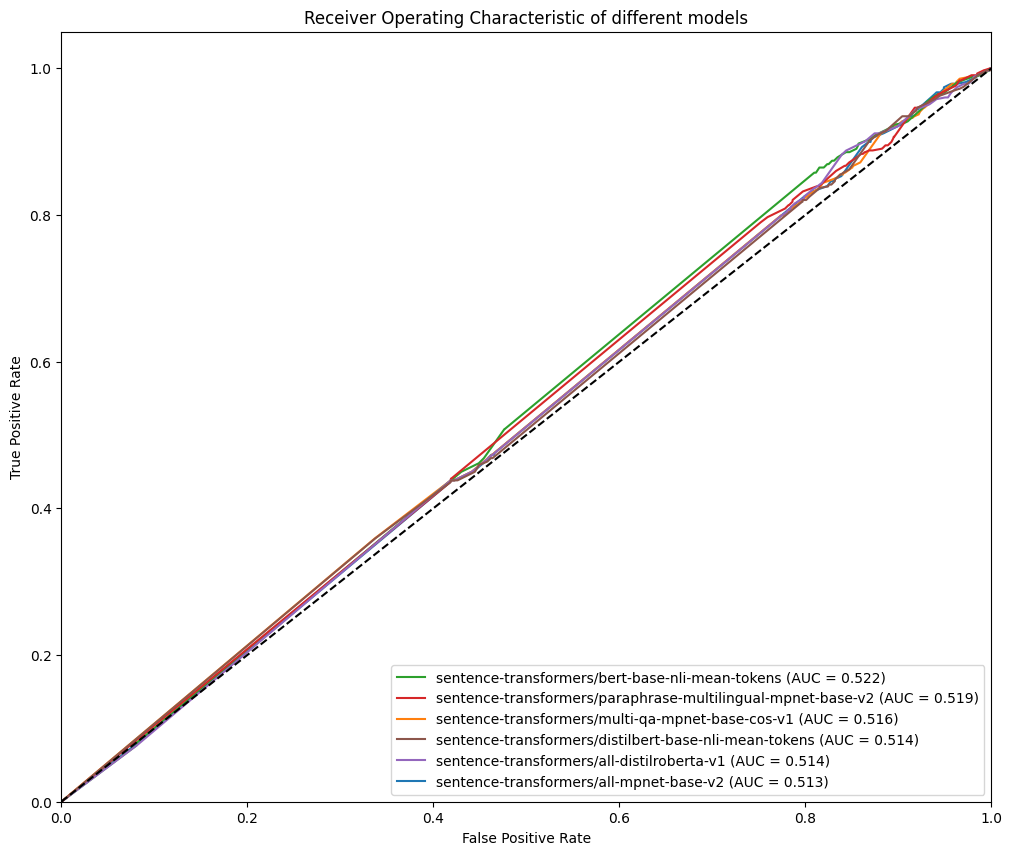

In [19]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

model_auc = {}
y_true = df['topic1'] == df['topic2']
fig = plt.figure(figsize=(12, 10))


def roc(model_name):
    y_score = df[model_name]
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    model_auc[model_name] = roc_auc

    plt.plot(fpr, tpr, label=model_name)


for model in models:
    roc(model)

# Order labels by each model's auc score
handles, labels = plt.gca().get_legend_handles_labels()
order = sorted(range(len(labels)), key=lambda k: -model_auc[labels[k]])
ordered_handles = [handles[idx] for idx in order]
ordered_labels = [f'{labels[idx]} (AUC = {model_auc[labels[idx]]:.3f})' for idx in order]
plt.legend(ordered_handles, ordered_labels, loc="lower right")

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic of different models')
plt.savefig('roc_structure_evaluation_train_315.eps')
plt.show()

In [20]:
model_auc

{'sentence-transformers/all-mpnet-base-v2': 0.5132046865004887,
 'sentence-transformers/multi-qa-mpnet-base-cos-v1': 0.5156703398044727,
 'sentence-transformers/bert-base-nli-mean-tokens': 0.5223119800282938,
 'sentence-transformers/paraphrase-multilingual-mpnet-base-v2': 0.5189242385729964,
 'sentence-transformers/all-distilroberta-v1': 0.5135300216991564,
 'sentence-transformers/distilbert-base-nli-mean-tokens': 0.5137815175754228}